### Using the backlink network to find link schemes to disproportionately link to unreliable news domains

In [2]:
import networkx as nx
import pandas as pd
from functools import reduce
import numpy as np
from enum import Enum

edge_df = pd.read_csv('../data/filtered_backlinks.csv')
edge_df.reset_index(inplace=True)
edge_df['domain_from'] = edge_df['domain_from'].str.lower()
edge_df['domain_to'] = edge_df['domain_to'].str.lower()
attrs = ['links','unique_pages']
node_mapping = {k: v for v, k in enumerate(set(list(edge_df.domain_from.unique()) + list(edge_df.domain_to.unique())))}

edge_df['domain_from_idx'] = edge_df.domain_from.map(node_mapping)
edge_df['domain_to_idx'] = edge_df.domain_to.map(node_mapping)

G_backlink = nx.from_pandas_edgelist(edge_df, source='domain_from_idx', target='domain_to_idx', edge_attr=attrs, create_using=nx.DiGraph())
len(G_backlink.nodes)

14959

In [3]:
url_df = pd.read_csv('../data/filtered_attrs.csv')
url_df['url'] = url_df['url'].str.lower()
url_df = url_df[['url','label']]

unreliable_targets = set([node_mapping[t] for t in list(edge_df.domain_to.unique()) if url_df.loc[url_df['url']==t]['label'].values[0] <= 4])

candidates = set()
for target in unreliable_targets:
    preds = list(G_backlink.predecessors(target))
    for pred in preds:
        candidates.add(pred)

link_scheme_stats = {}
for candidate in candidates:
    unreliable_link_count = 0
    unreliable_link_sum = 0
    for succ in G_backlink.successors(candidate):
        if succ in unreliable_targets:
            unreliable_link_count += 1
            unreliable_link_sum += G_backlink.get_edge_data(candidate, succ)['links']
    link_scheme_stats[candidate] = {}
    link_scheme_stats[candidate]['count'] = unreliable_link_count
    link_scheme_stats[candidate]['sum'] = unreliable_link_sum

breath_criteria = 3
depth_criteria = 400000

schemes = []
for (scheme, stats) in link_scheme_stats.items():
    if stats['count'] >= breath_criteria and stats['sum'] >= depth_criteria:
        schemes.append(scheme)
inv_node_mapping = {v: k for k, v in node_mapping.items()}
df = pd.DataFrame(data={"url": [inv_node_mapping[s] for s in schemes]})
df.to_csv("schemes.csv", index=False)
len(schemes)

251

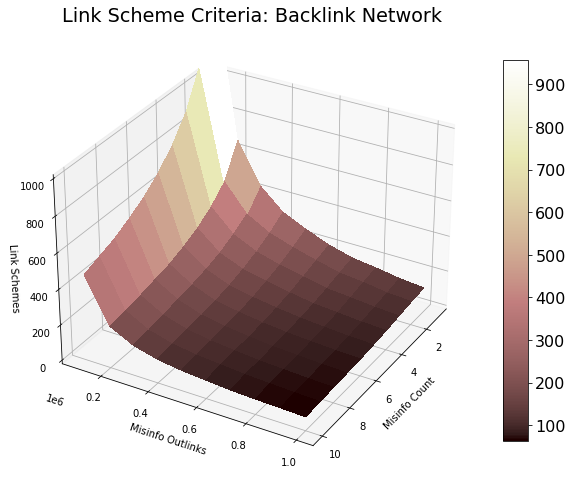

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
plt.rcParams['font.size'] = '16'
# Make data.
X_orig = np.arange(1,11,1)
Y_orig = np.arange(100000,1000001,100000)
X, Y = np.meshgrid(X_orig, Y_orig)
R = np.zeros((10, 10))

for (i,bc) in enumerate(list(X_orig)):
    for (j,dc) in enumerate(list(Y_orig)):
        count = 0
        for (target, stats) in link_scheme_stats.items():
            if stats['count'] >= bc and stats['sum'] >= dc:
                count += 1
        R[i][j] = count

surf = ax.plot_surface(X, Y, R, cmap=cm.pink,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(6))
fig.colorbar(surf, shrink=0.7, aspect=15)
fig.set_figheight(10)
fig.set_figwidth(10)
ax.view_init(30, 30)
ax.set_zlim(0,1000)
ax.set_ylabel('Misinfo Outlinks')
ax.set_xlabel('Misinfo Count')
ax.set_zlabel('Link Schemes')
plt.title('Link Scheme Criteria: Backlink Network')
plt.show()

### Bonus: using outlink network to find common destinations of links from unreliable news domains

In [6]:
out_edge_df = pd.read_csv('../data/filtered_outlinks.csv')
out_edge_df.reset_index(inplace=True)
out_edge_df['domain_from'] = out_edge_df['domain_from'].str.lower()
out_edge_df['domain_to'] = out_edge_df['domain_to'].str.lower()
attrs = ['links','unique_pages']
outlink_node_mapping = {k: v for v, k in enumerate(set(list(out_edge_df.domain_from.unique()) + list(out_edge_df.domain_to.unique())))}

out_edge_df['domain_from_idx'] = out_edge_df.domain_from.map(outlink_node_mapping)
out_edge_df['domain_to_idx'] = out_edge_df.domain_to.map(outlink_node_mapping)

G_outlink = nx.from_pandas_edgelist(out_edge_df, source='domain_from_idx', target='domain_to_idx', edge_attr=attrs, create_using=nx.DiGraph())

In [7]:
unreliable_targets_outlink = set([outlink_node_mapping[t] for t in url_df['url'] if t in outlink_node_mapping.keys() and url_df[url_df['url'] ==t]['label'].values[0] <= 4])

outlink_candidates = set()
for target in unreliable_targets_outlink:
    # current_node = node_mapping[target]
    succs = list(G_outlink.successors(target))
    for succ in succs:
        outlink_candidates.add(succ)

link_target_stats = {}
for candidate in outlink_candidates:
    unreliable_link_count = 0
    unreliable_link_sum = 0
    for pred in G_outlink.predecessors(candidate):
        if pred in unreliable_targets_outlink:
            unreliable_link_count += 1
            unreliable_link_sum += G_outlink.get_edge_data(pred, candidate)['links']
    link_target_stats[candidate] = {}
    link_target_stats[candidate]['count'] = unreliable_link_count
    link_target_stats[candidate]['sum'] = unreliable_link_sum

outlink_breath_criteria = 1
outlink_depth_criteria = 300000

link_targets = []
for (target, stats) in link_target_stats.items():
    # print(scheme)
    if stats['count'] >= outlink_breath_criteria and stats['sum'] >= outlink_depth_criteria:
        link_targets.append(target)

len(link_targets)

639

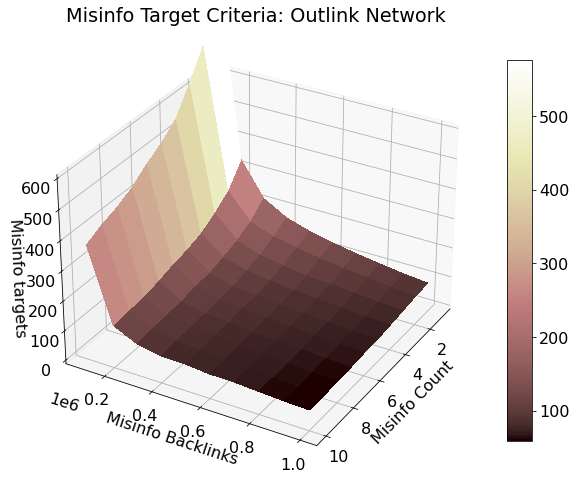

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import seaborn as sns

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X_orig = np.arange(1,11,1)
Y_orig = np.arange(100000,1000001,100000)
X, Y = np.meshgrid(X_orig, Y_orig)
R = np.zeros((10, 10))

for (i,bc) in enumerate(list(X_orig)):
    for (j,dc) in enumerate(list(Y_orig)):
        count = 0
        for (target, stats) in link_target_stats.items():
            if stats['count'] >= bc and stats['sum'] >= dc:
                count += 1
        R[i][j] = count

surf = ax.plot_surface(X, Y, R, cmap=cm.pink,
                       linewidth=0, antialiased=False)

fig.set_figheight(10)
fig.set_figwidth(10)
ax.set_zlim(0,600)
ax.zaxis.set_major_locator(LinearLocator(7))
fig.colorbar(surf, shrink=0.7, aspect=15)

ax.view_init(30, 30)
ax.set_ylabel('Misinfo Backlinks')
ax.set_xlabel('Misinfo Count')
ax.set_zlabel('Misinfo targets')
plt.title('Misinfo Target Criteria: Outlink Network')
plt.show()